## Load Data and Initial Grid Search

In [1]:
# Assign directory
import os
BRANDON = '/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/'
YASH = '/Users/yashd/Desktop/hierarchical-bayesian-model-validation/'
HANNAH = ''
ZIXUN = ''

ROOT_DIR = YASH
os.chdir(ROOT_DIR + 'testing-framework/')

DATA_NAME = 'full-pastis-gray-wavelet'
GROUP = 'layer'
SKIP_OPTIMIZE_STEP = True

# os.mkdir(DATA_NAME)
# os.mkdir(os.path.join(DATA_NAME, "CSVs"))
# os.mkdir(os.path.join(DATA_NAME, "plots"))

In [2]:
from utilities import *
from plot_utilities import *
''' Comment out the below two lines if you do not have Matlab installed and opened'''
# import matlab.engine 
# eng = matlab.engine.connect_matlab()

np.random.seed(42)

In [3]:
''' Only need to run commented code once'''
# data_df = pd.read_pickle(f'../transformed-data/{DATA_NAME}.pickle')
# min_group, max_group = 2, max(data_df[GROUP])
# group_data_map = dict()
# for group in np.arange(min_group, max_group + 1):
#     data = np.append(data_df[(data_df['orientation'] == 'H') & (data_df[GROUP] == group)]['data'].iloc[0],
#                      data_df[(data_df['orientation'] == 'V') & (data_df[GROUP] == group)]['data'].iloc[0])
#     group_data_map[group] = np.sort(data)#[np.random.permutation(data.size)[:min(data.size, 100000)]])
# pd.to_pickle(group_data_map, f'{DATA_NAME}/group_data_map.pickle')

group_data_map = pd.read_pickle(f'{DATA_NAME}/group_data_map.pickle')
min_group, max_group = 2, sorted(group_data_map)[-1]
group_data_map

{2: array([-99.93568594, -99.93568594, -99.93568594, ...,  94.44944672,
         94.44944672,  94.44944672]),
 3: array([-76.13432886, -76.13432886, -76.13432886, ...,  69.44498554,
         69.44498554,  69.44498554]),
 4: array([-51.73647153, -48.46756551, -48.46756551, ...,  50.33643736,
         50.33643736,  64.88734264]),
 5: array([-47.95678457, -36.2290875 , -34.21402956, ...,  32.91894773,
         36.11999915,  42.17747737]),
 6: array([-23.87540781, -21.69502371, -19.77842932, ...,  18.532206  ,
         21.00124659,  44.79754701]),
 7: array([-19.12997336, -11.63154378, -10.24156022, ...,  10.34018388,
         11.58181396,  20.30569957]),
 8: array([-18.71256003,  -5.38310051,  -4.75432793, ...,   4.71546986,
          5.46900035,  20.5891778 ])}

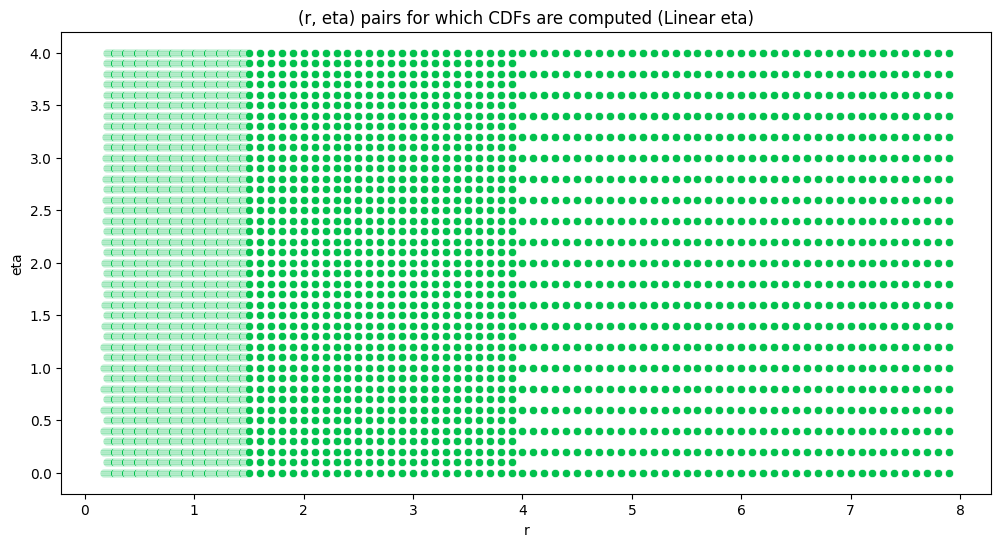

,r,eta,variance,kurtosis
count,7231.000000,7231.000000,7.231000e+03,7231.000000
mean,1.697681,1.996211,1.004866e+05,1.472754
std,1.767213,1.186497,1.186843e+06,2.016586
min,0.170000,0.000000,5.831855e-01,0.108688
25%,0.630000,1.000000,1.242050e+00,0.505888
50%,1.070000,2.000000,2.890964e+00,0.872971
75%,1.600000,3.000000,1.561979e+01,1.617836
max,7.900000,4.000000,3.481970e+07,33.893293


In [4]:
# Large grid search CDFs already computed (r = 0 to 8, eta = 0 to 3.9)

all_cdfs = combine_pickles('scipy_10000') | combine_pickles('mtlb_10000') | combine_pickles('mtlb_100000')
all_cdfs_df = pd.DataFrame({'(r,eta),cdf' : sorted(all_cdfs.items())})
all_cdfs_df['r'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[0].str[0])
all_cdfs_df['eta'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[0].str[1])
all_cdfs_df['cdf'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[1])
all_cdfs_df['variance'] = all_cdfs_df.apply(lambda row : variance_prior(row.loc['r'],row.loc['eta']), axis = 1)
all_cdfs_df['kurtosis'] = all_cdfs_df.apply(lambda row : kurtosis_prior(row.loc['r'],row.loc['eta']), axis = 1)
revised_grid_df = pd.DataFrame()
filtered_df_dict = dict()
create_scatter_plot(all_cdfs_df)

all_cdfs_df.describe()

In [5]:
col = 'r'
# create_scatter_plots_log_eta(all_cdfs_df[(all_cdfs_df[col] > 1) & (all_cdfs_df[col] < 2)], metric='kurtosis')
# create_scatter_plots(all_cdfs_df[(all_cdfs_df[col] > 1) & (all_cdfs_df[col] < 2)], metric1='kurtosis', metric2='variance')
# create_scatter_plots(all_cdfs_df[(all_cdfs_df[col] > 1) & (all_cdfs_df[col] < 2)], metric1='kurtosis', metric2='variance')

No CDFs match criteria
CDF with closest variance: (0.4, 4.0)
CDF with closest kurtosis: (7.9, 4.0)


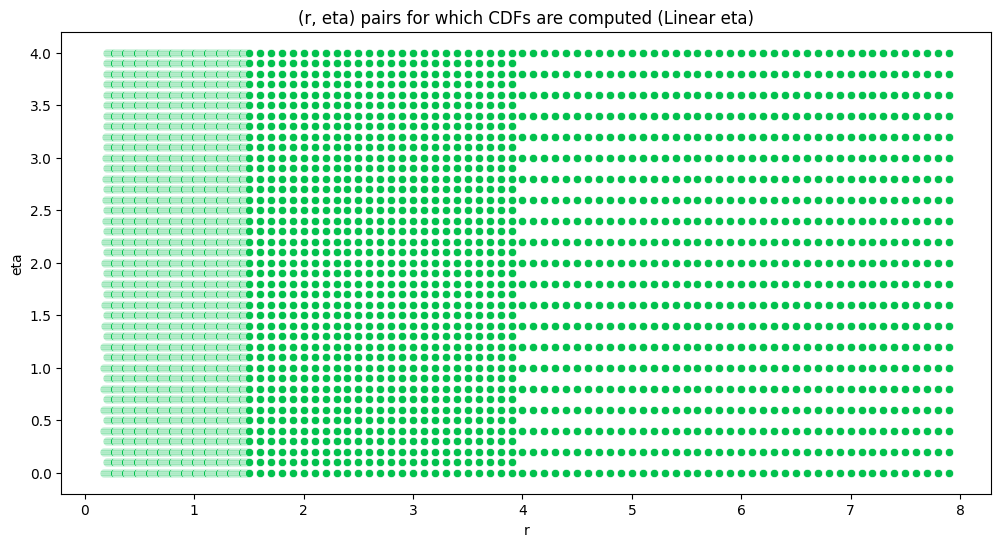

No CDFs match criteria
CDF with closest variance: (0.4, 2.0)
CDF with closest kurtosis: (3.0, 1.8)


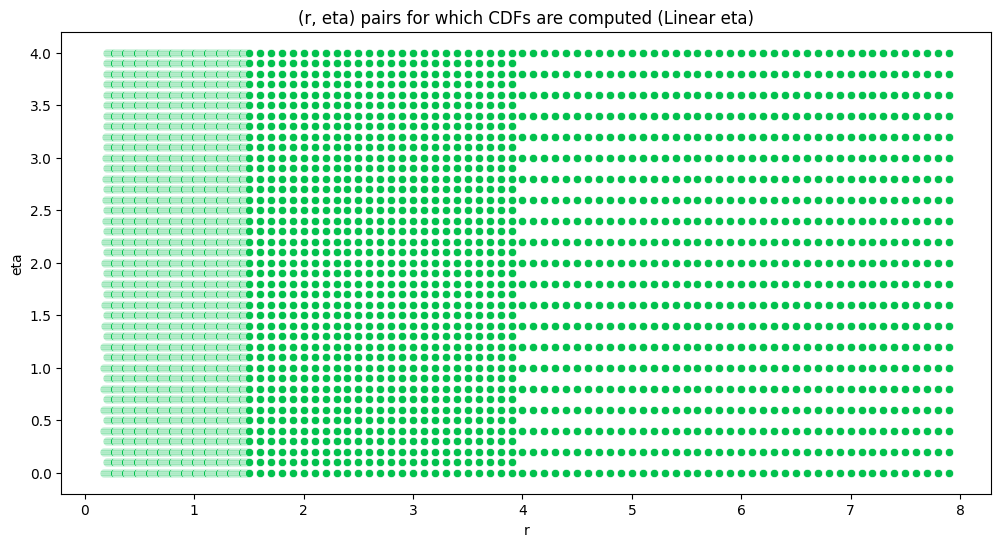

Layer 4: Filtering for CDFs whose 
variance is between 53.89670018482353 and 110.25693292709298, 
kurtosis is between 0.5243301064010113 and 2.2806030329211167
Empirical Variance of sample: 80.7999458601304
Empirical Kurtosis of sample: 1.3308747771439293


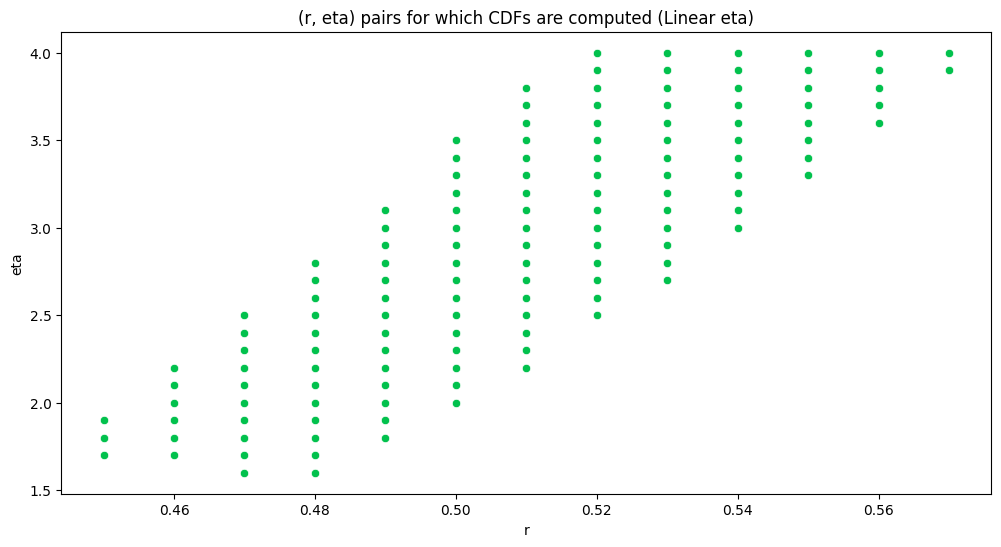

Layer 5: Filtering for CDFs whose 
variance is between 13.126183832185681 and 27.35182165539709, 
kurtosis is between 1.727280891216557 and 5.543341796500031
Empirical Variance of sample: 19.88230515098137
Empirical Kurtosis of sample: 3.074957053632871


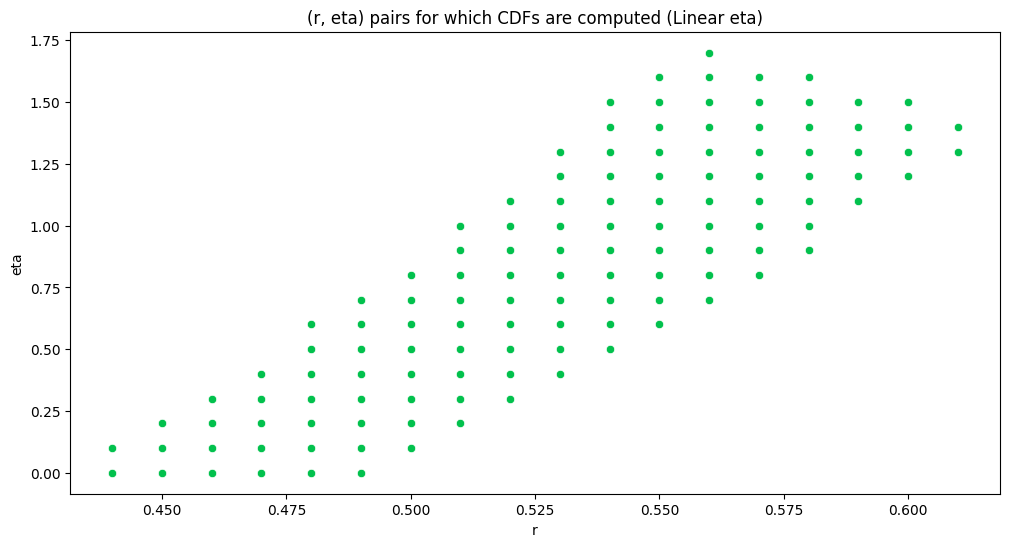

Layer 6: Filtering for CDFs whose 
variance is between 2.7172169116195635 and 5.967901161001177, 
kurtosis is between 3.362615062617022 and 28.908993655497166
Empirical Variance of sample: 4.187364553076183
Empirical Kurtosis of sample: 7.592764224378456


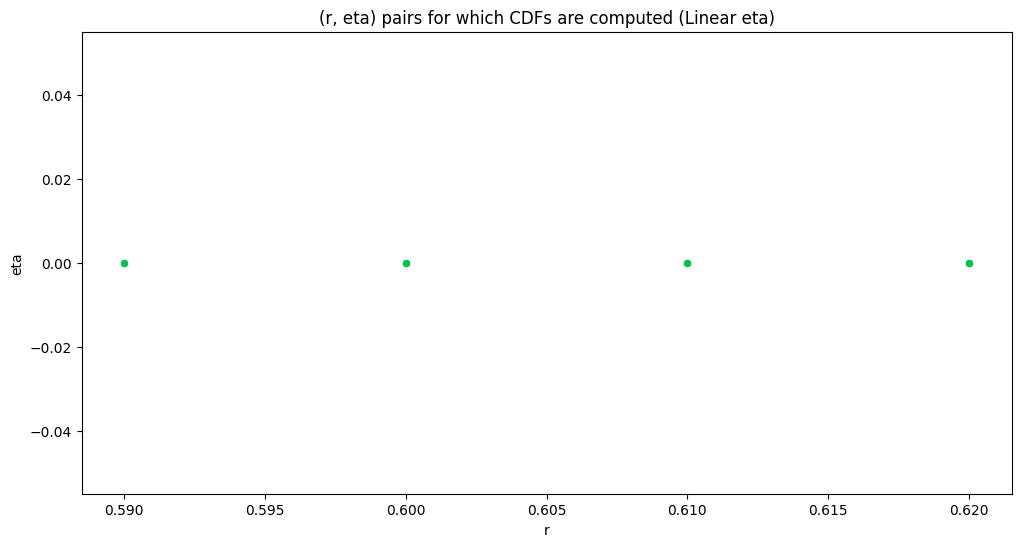

No CDFs match criteria
CDF with closest variance: (2.3, 0.5)
CDF with closest kurtosis: (0.21, 0.5)


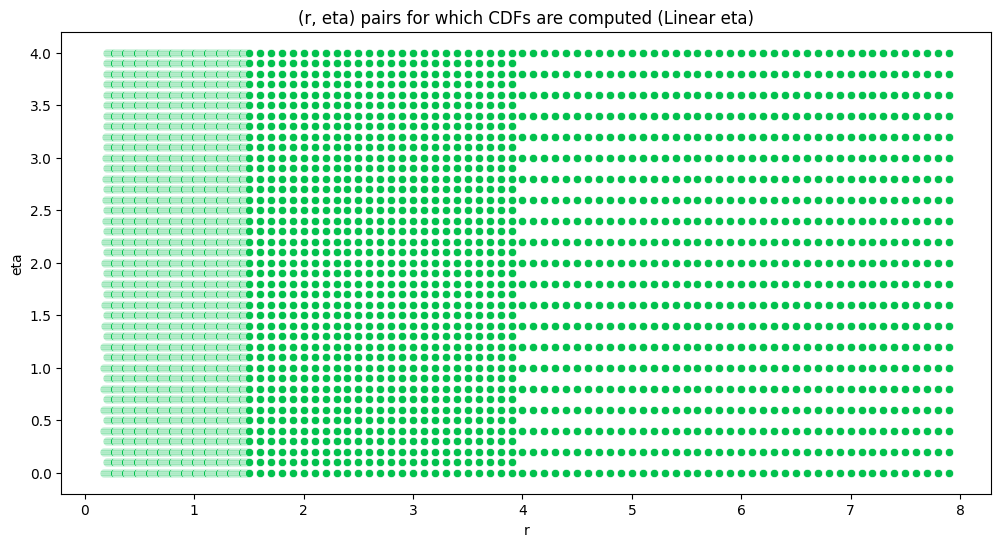

No CDFs match criteria
CDF with closest variance: (7.9, 0.0)
CDF with closest kurtosis: (0.17, 0.0)


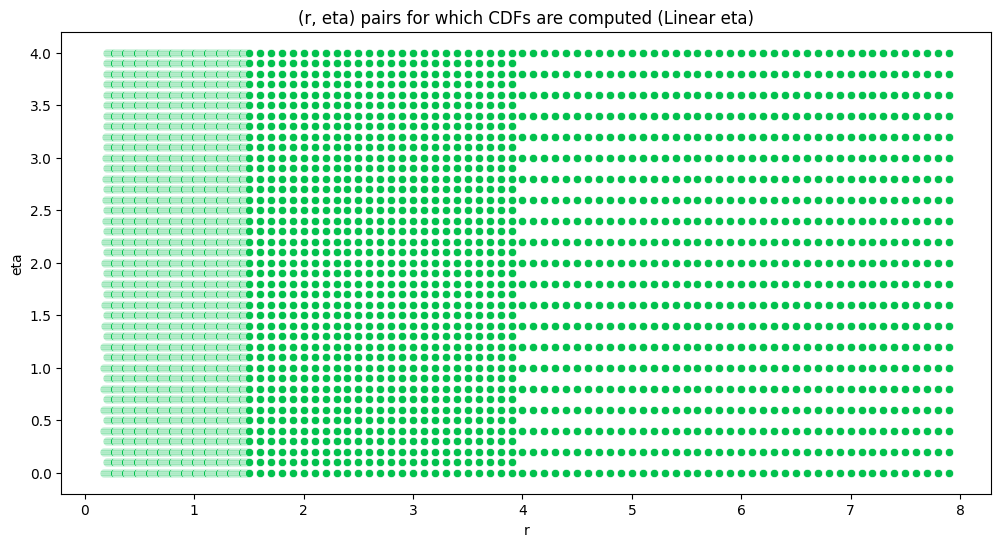

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper
2,800.841427,771.812597,831.263951,0.073599,-0.032075,0.183998
3,274.912444,264.134769,285.830103,0.356110,0.208268,0.508480
4,80.799946,76.995286,84.813025,1.330875,1.024330,1.780603
5,19.882305,18.751691,21.039863,3.074957,2.227281,5.043342
6,4.187365,3.881738,4.590693,7.592764,3.862615,28.408994
7,0.819285,0.747686,0.915603,13.123555,6.003857,47.250920
8,0.136744,0.117270,0.211657,172.661568,8.152905,761.224109


In [6]:
eps_var = 0.3
eps_kurt = 0.5
for group in np.arange(min_group, max_group+1):
    revised_grid_df.loc[group, 'obs_var'], revised_grid_df.loc[group, 'var_lower'], revised_grid_df.loc[group, 'var_upper'], _ = bootstrap_metric(group_data_map[group], n_bootstrap=10000, metric= np.var, ci=0.99)
    revised_grid_df.loc[group, 'obs_kurt'], revised_grid_df.loc[group, 'kurt_lower'], revised_grid_df.loc[group, 'kurt_upper'], _ = bootstrap_metric(group_data_map[group], n_bootstrap=10000, metric= stats.kurtosis, ci=0.99)    
    filtered_df = all_cdfs_df[(all_cdfs_df['variance'] > (1-eps_var)*revised_grid_df.loc[group, 'var_lower']) &
                          (all_cdfs_df['variance'] < (1+eps_var)*revised_grid_df.loc[group, 'var_upper']) &
                          (all_cdfs_df['kurtosis'] > (revised_grid_df.loc[group, 'kurt_lower'] - eps_kurt)) &
                          (all_cdfs_df['kurtosis'] < (revised_grid_df.loc[group, 'kurt_upper']) + eps_kurt)]
    
    if filtered_df.shape[0] == 0:
        filtered_df = all_cdfs_df
        print("No CDFs match criteria")
        temp = all_cdfs_df.copy()
        temp['diff_var'] = np.abs(temp['variance'] - revised_grid_df.loc[group, 'obs_var'])
        temp['diff_kurt'] = np.abs(temp['kurtosis'] - revised_grid_df.loc[group, 'obs_kurt'])
        closest_var = temp[temp['diff_var'] == temp['diff_var'].min()][['r', 'eta']]
        closest_kurt = temp[temp['diff_kurt'] == temp['diff_kurt'].min()][['r', 'eta']]
        print(f"CDF with closest variance: {closest_var.iloc[0, 0], closest_var.iloc[0, 1]}")
        print(f"CDF with closest kurtosis: {closest_kurt.iloc[0, 0], closest_kurt.iloc[0, 1]}")
        del temp
    else:
        print(f"{GROUP.capitalize()} {group}: Filtering for CDFs whose \nvariance is between {(1-eps_var)*revised_grid_df.loc[group, 'var_lower']} and {(1+eps_var)*revised_grid_df.loc[group, 'var_upper']}, \nkurtosis is between {revised_grid_df.loc[group, 'kurt_lower'] - eps_kurt} and {revised_grid_df.loc[group, 'kurt_upper'] + eps_kurt}")
        print(f"Empirical Variance of sample: {revised_grid_df.loc[group, 'obs_var']}")
        print(f"Empirical Kurtosis of sample: {revised_grid_df.loc[group, 'obs_kurt']}")
    
    filtered_df_dict[group] = filtered_df
    # create_scatter_plots(filtered_df, metric1='kurtosis', metric2='variance')
    create_scatter_plot(filtered_df)
revised_grid_df = revised_grid_df.rename(index={'0':GROUP})
revised_grid_df

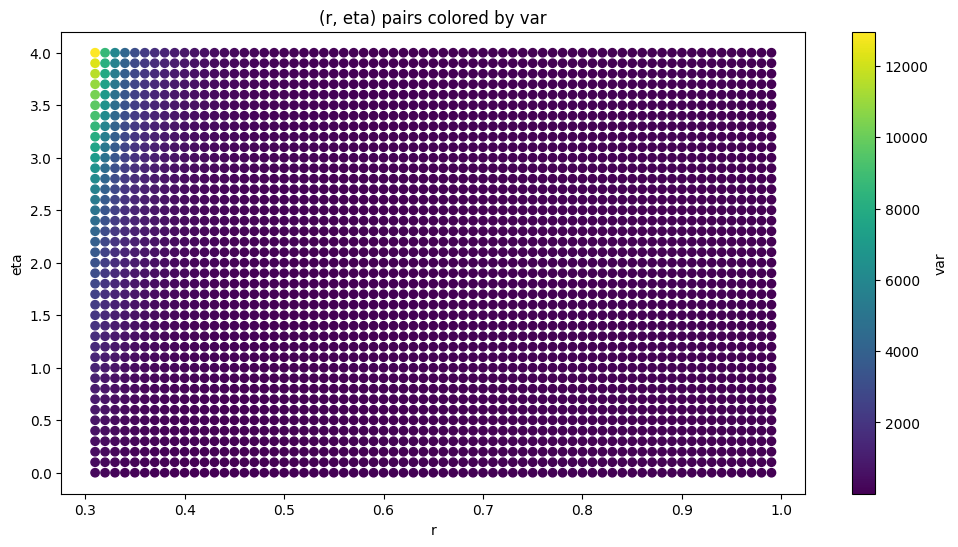

In [31]:
def create_contour_plot(df, metric):
    """
    Create a contour plot with a semi-transparent heatmap in the background, where the color represents the values from the specified metric column.
    
    Arguments:
    df -- A pandas DataFrame containing the columns 'r', 'eta', and the specified metric column.
    metric -- The name of the column in the DataFrame to use for color mapping.
    """
    # Create a meshgrid from r and eta
    r_meshgrid, eta_meshgrid = np.meshgrid(df['r'].unique(), df['eta'].unique())
    
    metric_meshgrid = np.zeros_like(r_meshgrid)
    for i, r in enumerate(df['r'].unique()):
        for j, eta in enumerate(df['eta'].unique()):
            mask = (df['r'] == r) & (df['eta'] == eta)
            if mask.any():
                metric_meshgrid[j, i] = df.loc[mask, metric].values[0]
    
    fig, ax = plt.subplots(figsize=(6, 12))
    
    heatmap = ax.imshow(metric_meshgrid, extent=[df['r'].min(), df['r'].max(), df['eta'].min(), df['eta'].max()], origin='lower', cmap='viridis', alpha=0.5)
    
    contour = ax.contour(r_meshgrid, eta_meshgrid, metric_meshgrid, cmap='viridis')
    cbar = fig.colorbar(heatmap, ax=ax)
    cbar.set_label(metric)
    
    ax.clabel(contour, inline=True, fontsize=10)
    ax.set_xlabel('r')
    ax.set_ylabel('eta')
    ax.set_title('Contour Plot (r, eta) colored by {}'.format(metric))
    
    plt.show()

#create_contour_plot(all_cdfs_df[(all_cdfs_df['eta'] < 2) & (all_cdfs_df['r'] < 2)], 'kurt')
create_scatter_plot(all_cdfs_df[(all_cdfs_df['r'] < 1) & (all_cdfs_df['r'] > 0.3)], 'var')

In [5]:
''' Only need to run commented code once'''

master_df = pd.DataFrame(columns = [GROUP, 'num_samples', 'initial_param', 'kstest_stat_initial', 'best_param_eta_0', 'kstest_stat_eta0'])
idx_eta0 = [i for i, param in enumerate(sorted(all_cdfs)) if np.isclose(param[1], 0, atol = 1e-40)]
sorted_params = sorted(all_cdfs)
for i, group in enumerate(np.arange(min_group, max_group+1)):
    print("Processing group (layer/band) ", group)
    sample = group_data_map[group]
    group_cdfs = {i[0]:i[1] for i in filtered_df_dict[group]}
    ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs)
    ksstats_eta0 = [ksstats[i] for i in idx_eta0]
    idx_min_ksstats_eta0 = idx_eta0[np.argmin(ksstats_eta0)]
    master_df.loc[i, :] = [group, sample.size, initial_param, min_stat, sorted_params[idx_min_ksstats_eta0], ksstats[idx_min_ksstats_eta0]]
master_df = master_df.set_index(GROUP)
master_df.to_csv(f'{DATA_NAME}/CSVs/initial_eta0_grid.csv')

min_group, max_group = 2, 8
master_df = pd.read_csv(f'{DATA_NAME}/CSVs/initial_eta0_grid.csv', index_col=GROUP)
master_df['initial_param'] = [tuple(float(i) for i in master_df.loc[group]['initial_param'][1:-1].split(',')) for group in master_df.index]
master_df

,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta0
layer,,,,,
2,3180,"(0.39, 4.0)",0.021670,"(0.26, 0)",0.060374
3,12720,"(0.44, 3.7)",0.008143,"(0.29, 0)",0.037031
4,50880,"(0.44, 1.4)",0.006270,"(0.34, 0)",0.023245
5,203520,"(0.47, 0.2)",0.005235,"(0.44, 0)",0.005645
6,814080,"(0.74, 0.0)",0.020505,"(0.74, 0)",0.020505
7,3256320,"(6.1, 0.0)",0.082279,"(6.1, 0)",0.082279
8,13025280,"(6.0, 0.0)",0.227356,"(6.0, 0)",0.227356


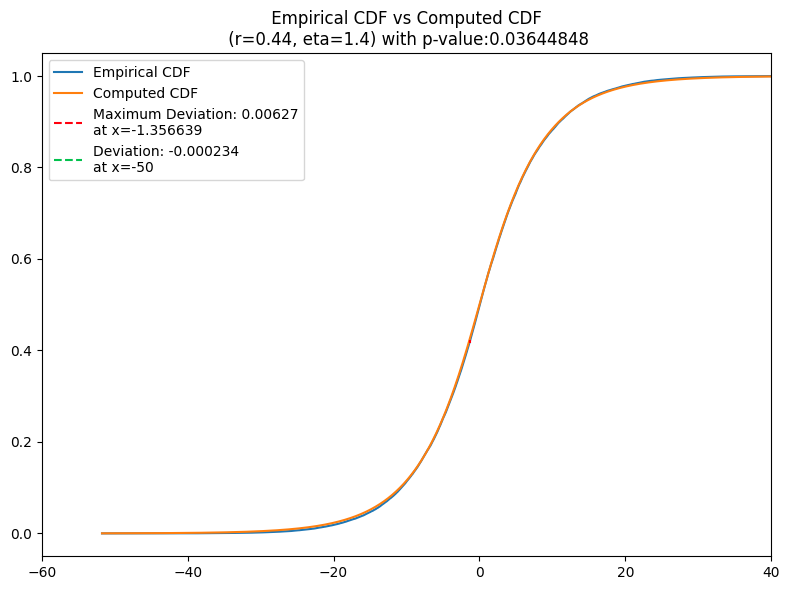

In [6]:
group = 4
visualize_cdf(group_data_map[group], 
              all_cdfs = all_cdfs, 
              params= master_df.loc[group, 'initial_param'], 
              n_samples=10000, interval = (-60, 40), 
              provided_loc = -50);

In [7]:
# Given that pvalue = 0.05 and I have n samples, what should the kstest statistic be?
# Note how as num_samples increases by a factor of 4, the cutoff decreases by a factor of 2
# Could potentially include the plot in `images/loglog_pvalue_numsamples.png` 

for group in np.arange(min_group, max_group+1):
    num_points = group_data_map[group].size
    master_df.loc[group, 'kstest_stat_cutoff_0.05'] = stats.kstwo(n=num_points).isf(0.05)    
master_df

,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta0,kstest_stat_cutoff_0.05
layer,,,,,,
2,3180,"(0.39, 4.0)",0.021670,"(0.26, 0)",0.060374,0.024030
3,12720,"(0.44, 3.7)",0.008143,"(0.29, 0)",0.037031,0.012029
4,50880,"(0.44, 1.4)",0.006270,"(0.34, 0)",0.023245,0.006018
5,203520,"(0.47, 0.2)",0.005235,"(0.44, 0)",0.005645,0.003010
6,814080,"(0.74, 0.0)",0.020505,"(0.74, 0)",0.020505,0.001505
7,3256320,"(6.1, 0.0)",0.082279,"(6.1, 0)",0.082279,0.000753
8,13025280,"(6.0, 0.0)",0.227356,"(6.0, 0)",0.227356,0.000376


In [8]:
r_d, eta_d = 3, 2 # Controls precision to which parameters are optimized
SKIP_OPTIMIZE_STEP = True

if SKIP_OPTIMIZE_STEP:
    r_d, eta_d = 2, 1
    master_df['kstest_stat_cd'] = master_df['kstest_stat_initial']
    master_df[f'best_r_d{r_d}'] = master_df['initial_param'].apply(lambda x : x[0])
    master_df[f'best_eta_d{eta_d}'] = master_df['initial_param'].apply(lambda x : x[1])

else:
    for group in np.arange(min_group, max_group+1): 
        sample = group_data_map[group]
        initial_param = master_df.loc[group, 'initial_param']
        master_df.loc[group, f'best_r_d{r_d}'], master_df.loc[group, f'best_eta_d{eta_d}'] = coord_descent_gengamma(sample, initial_param, 
                                                                                                                    r_depth = r_d, eta_depth=eta_d, 
                                                                                                                    scipy_int=False, group=group, 
                                                                                                                    eng=eng, DATA_NAME=DATA_NAME)
        master_df.loc[group, 'kstest_stat_cd'] = compute_ksstat(sample, combine_pickles(f'{DATA_NAME}_group{group}_10000')[(master_df.loc[group, f'best_r_d{r_d}'], master_df.loc[group, f'best_eta_d{eta_d}'])])
        print(f"{GROUP} {group} best parameters: {master_df.loc[group, 'kstest_stat_cd']}")


master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_cd'], row.loc['num_samples']), axis = 1)    
master_df[['num_samples', 'initial_param', 'kstest_stat_initial', f'best_r_d{r_d}', f'best_eta_d{eta_d}', 'kstest_stat_cd', 'n_pval_0.05']].to_csv(f'{DATA_NAME}/CSVs/optimized_params.csv')
master_df.to_csv(f'{DATA_NAME}/CSVs/master_df_post_optimize.csv')

master_df = pd.read_csv(f'{DATA_NAME}/CSVs/master_df_post_optimize.csv', index_col = GROUP)
master_df['initial_param'] = [tuple(float(i) for i in master_df.loc[group]['initial_param'][1:-1].split(',')) for group in master_df.index]
master_df

,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta0,kstest_stat_cutoff_0.05,kstest_stat_cd,best_r_d2,best_eta_d1,n_pval_0.05
layer,,,,,,,,,,
2,3180,"(0.39, 4.0)",0.021670,"(0.26, 0)",0.060374,0.024030,0.021670,0.39,4.0,4023
3,12720,"(0.44, 3.7)",0.008143,"(0.29, 0)",0.037031,0.012029,0.008143,0.44,3.7,28620
4,50880,"(0.44, 1.4)",0.006270,"(0.34, 0)",0.023245,0.006018,0.006270,0.44,1.4,48295
5,203520,"(0.47, 0.2)",0.005235,"(0.44, 0)",0.005645,0.003010,0.005235,0.47,0.2,64395
6,814080,"(0.74, 0.0)",0.020505,"(0.74, 0)",0.020505,0.001505,0.020505,0.74,0.0,4525
7,3256320,"(6.1, 0.0)",0.082279,"(6.1, 0)",0.082279,0.000753,0.082279,6.10,0.0,279
8,13025280,"(6.0, 0.0)",0.227356,"(6.0, 0)",0.227356,0.000376,0.227356,6.00,0.0,36


## Comparing Empirical and Computed CDF/PDF

Chebyshev bound: 142.377113752867
First CDF value: 3.995114116092164e-12
Last CDF value: 0.9969749647558226
0, 1 padding bounds: 1000000.0


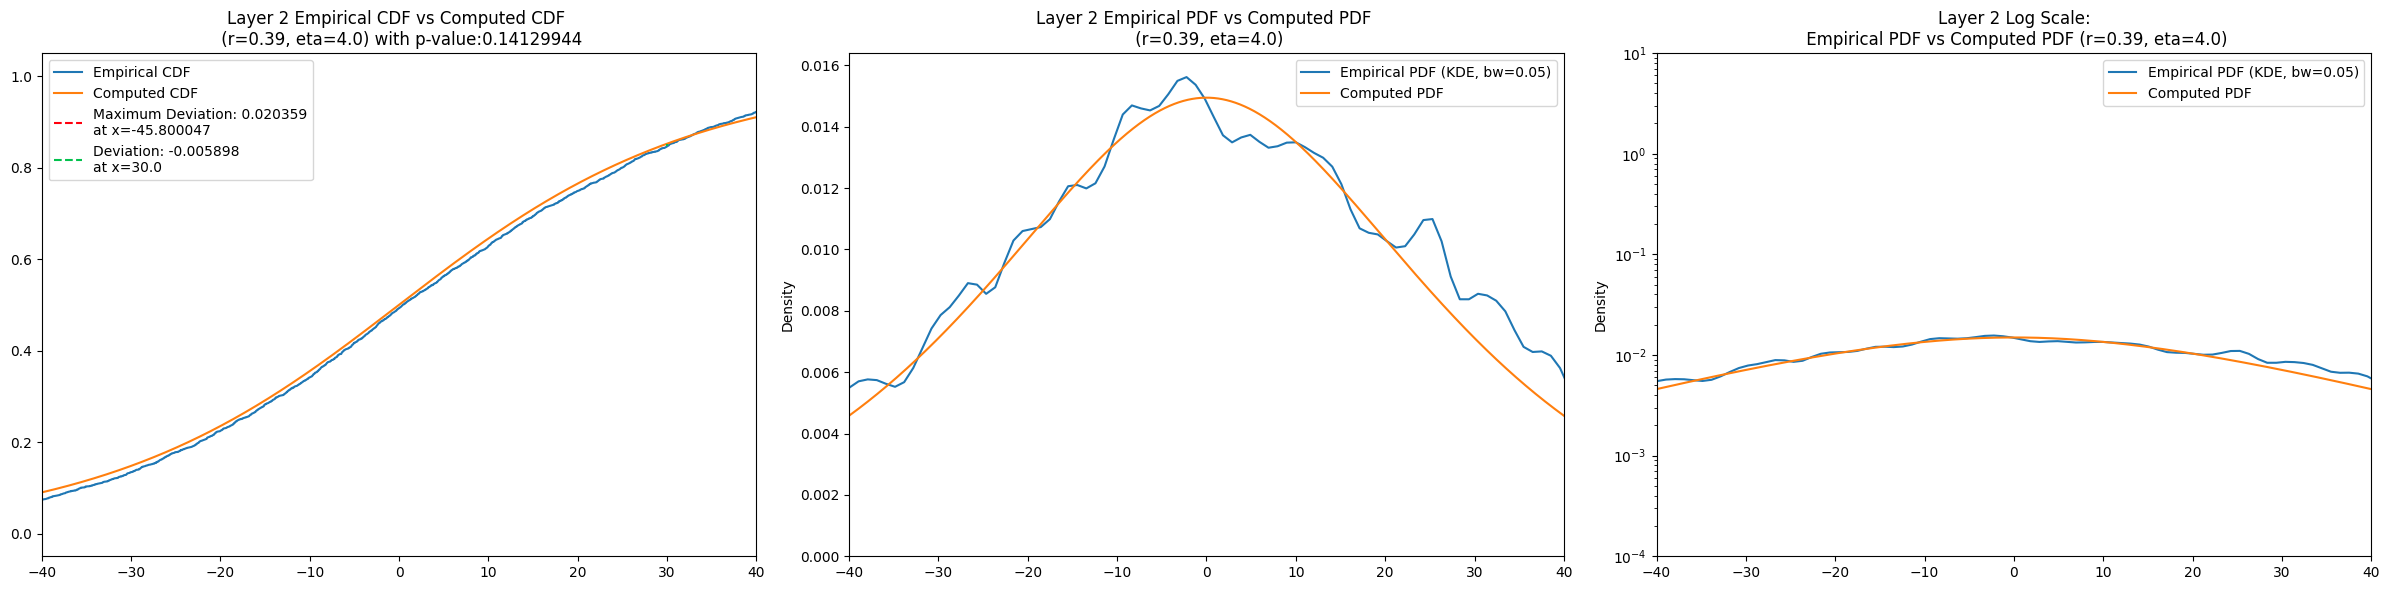

No tail
Chebyshev bound: 78.46081890770525
First CDF value: 5.507148241361813e-07
Last CDF value: 0.9992916761941001
0, 1 padding bounds: 1000000.0


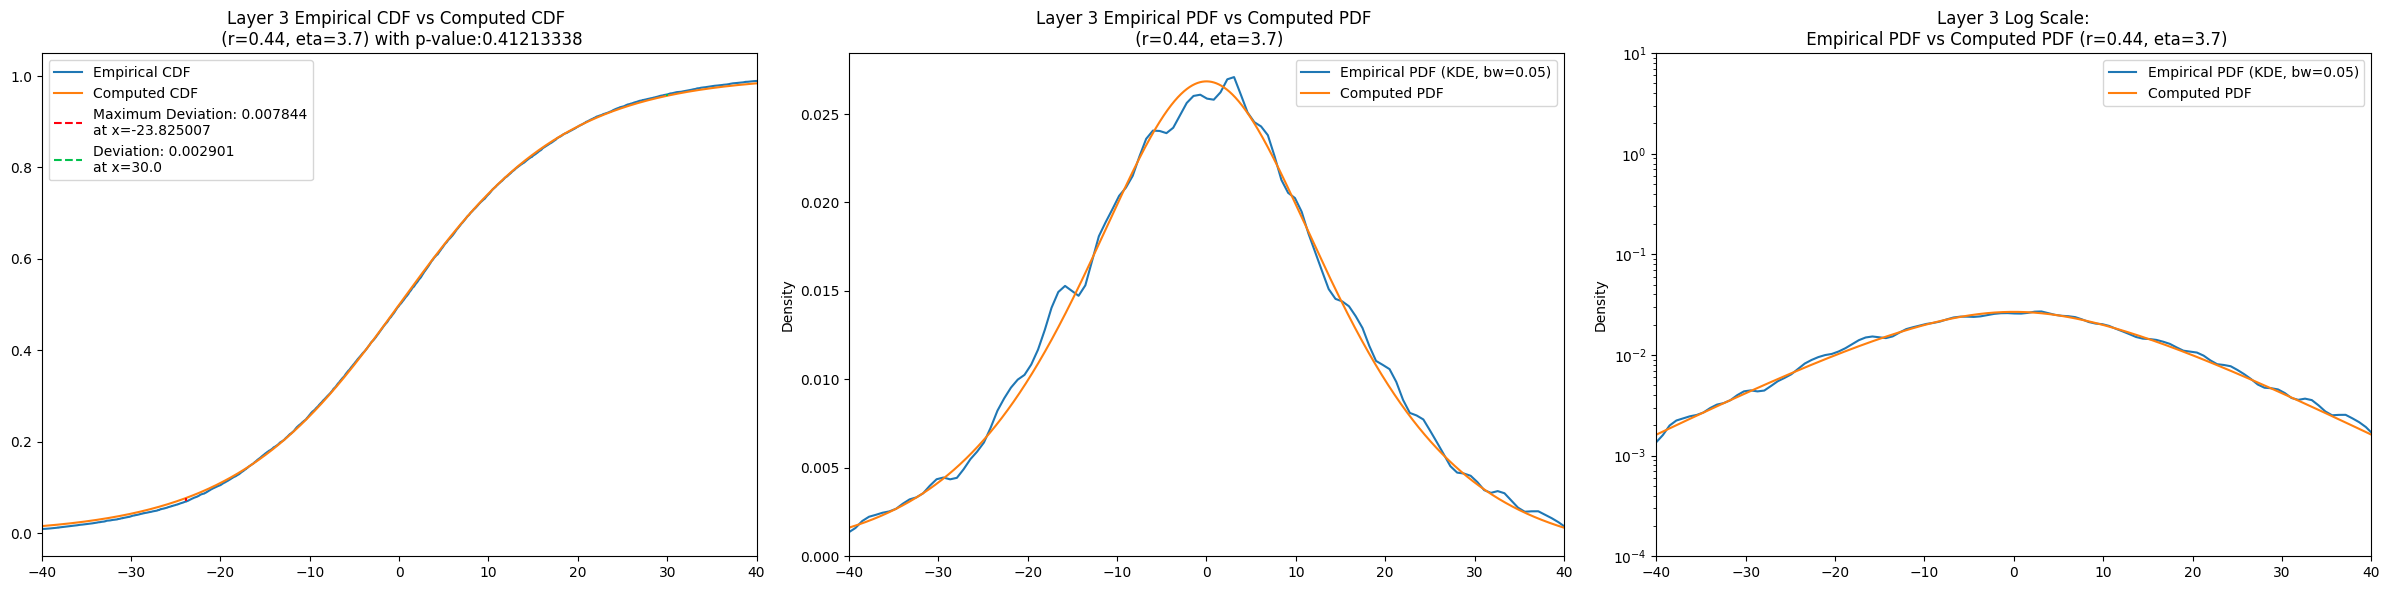

No tail
Chebyshev bound: 42.167304052604024
First CDF value: 9.697496609613425e-07
Last CDF value: 0.9984281058333783
0, 1 padding bounds: 1000000.0


c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\testing-framework\utilities.py:87: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  prior_pdf[j] = integrate.quad(integrand, 0, np.inf)[0]


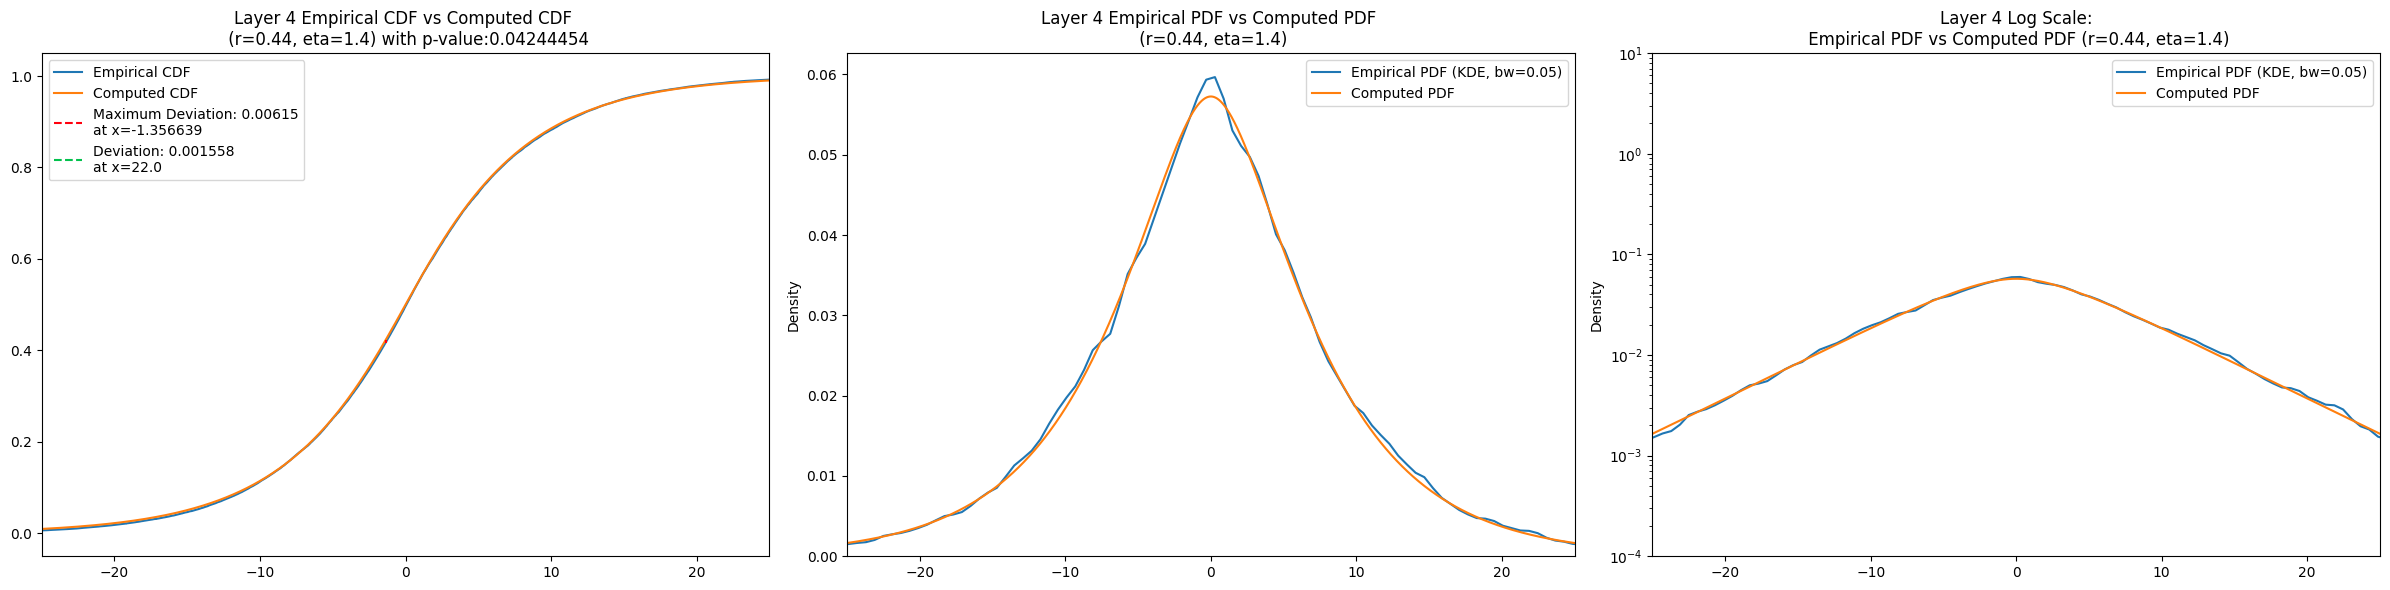

No tail
Chebyshev bound: 20.300820925496282
First CDF value: 1.3849825754018901e-06
Last CDF value: 0.9973242174031235
0, 1 padding bounds: 1000000.0


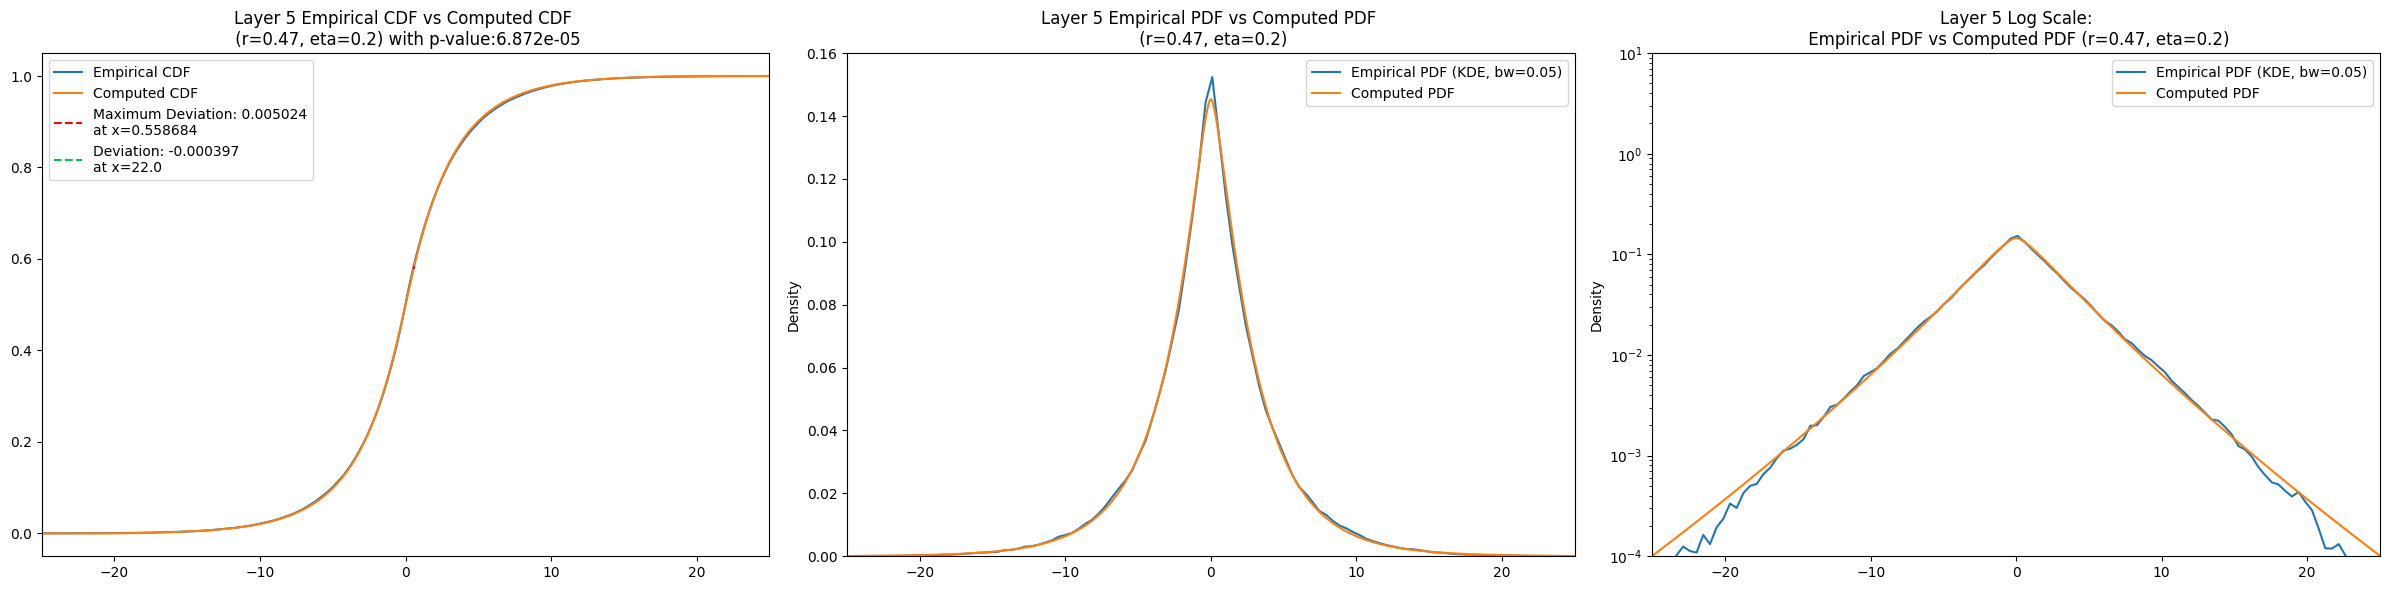

No tail
Chebyshev bound: 7.588825747498706
First CDF value: 1.0410903279315122e-06
Last CDF value: 0.9983483436317541
0, 1 padding bounds: 1000000.0


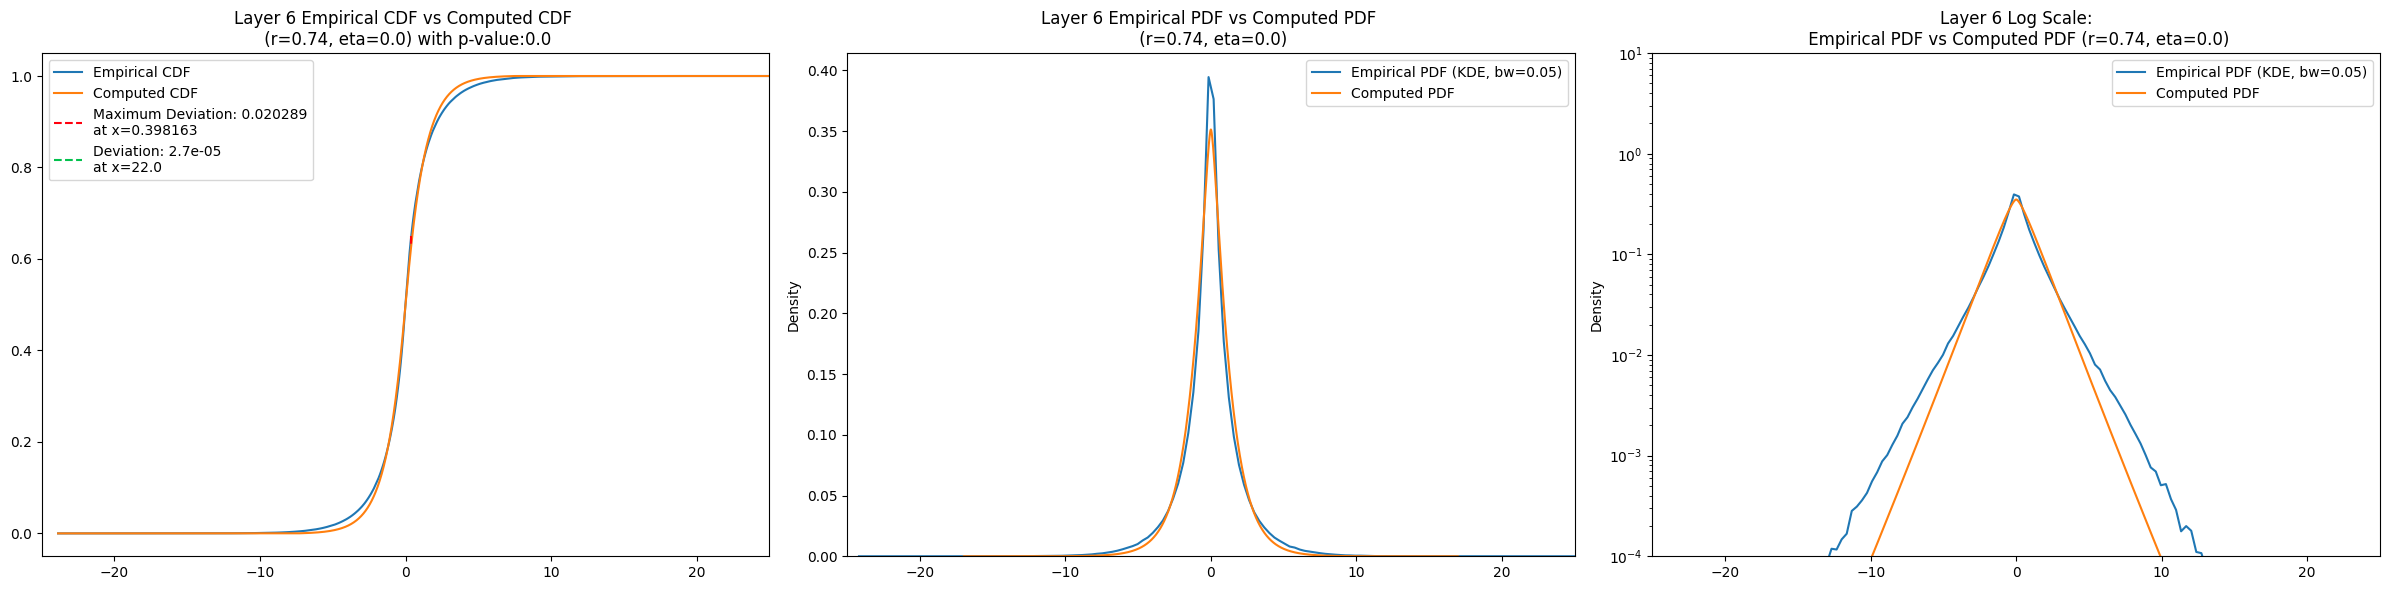

No tail
Chebyshev bound: 3.424770589780717
First CDF value: 1.7854618806850398e-07
Last CDF value: 0.9998619918291485
0, 1 padding bounds: 1000000.0


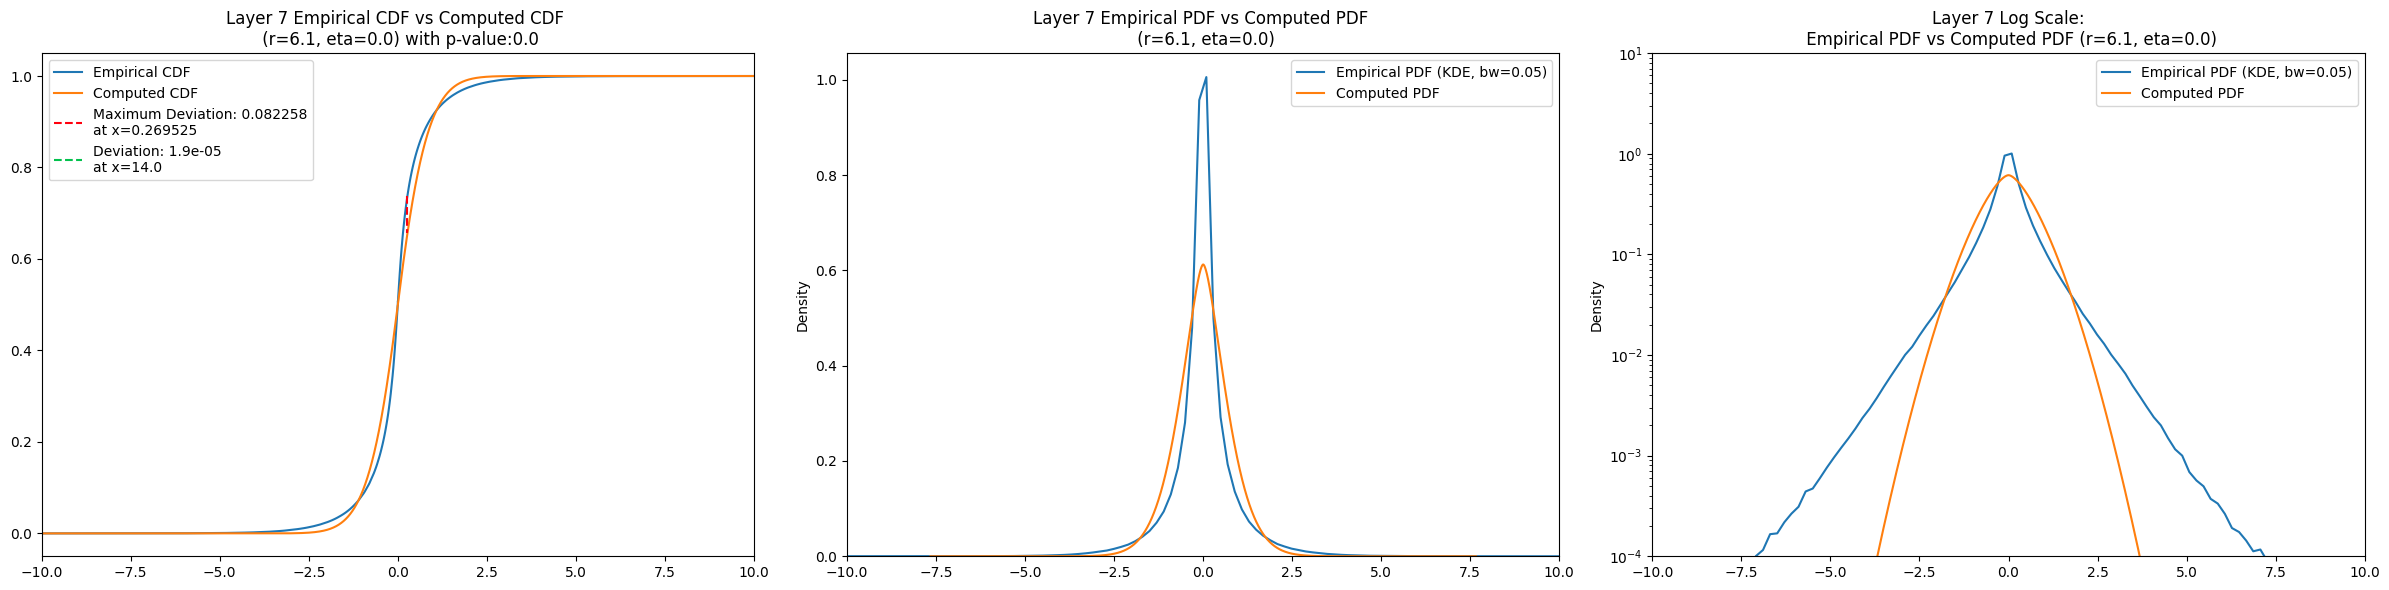

No tail
Chebyshev bound: 3.4258241645696366
First CDF value: 1.7980729374092142e-07
Last CDF value: 0.9998606913119513
0, 1 padding bounds: 1000000.0


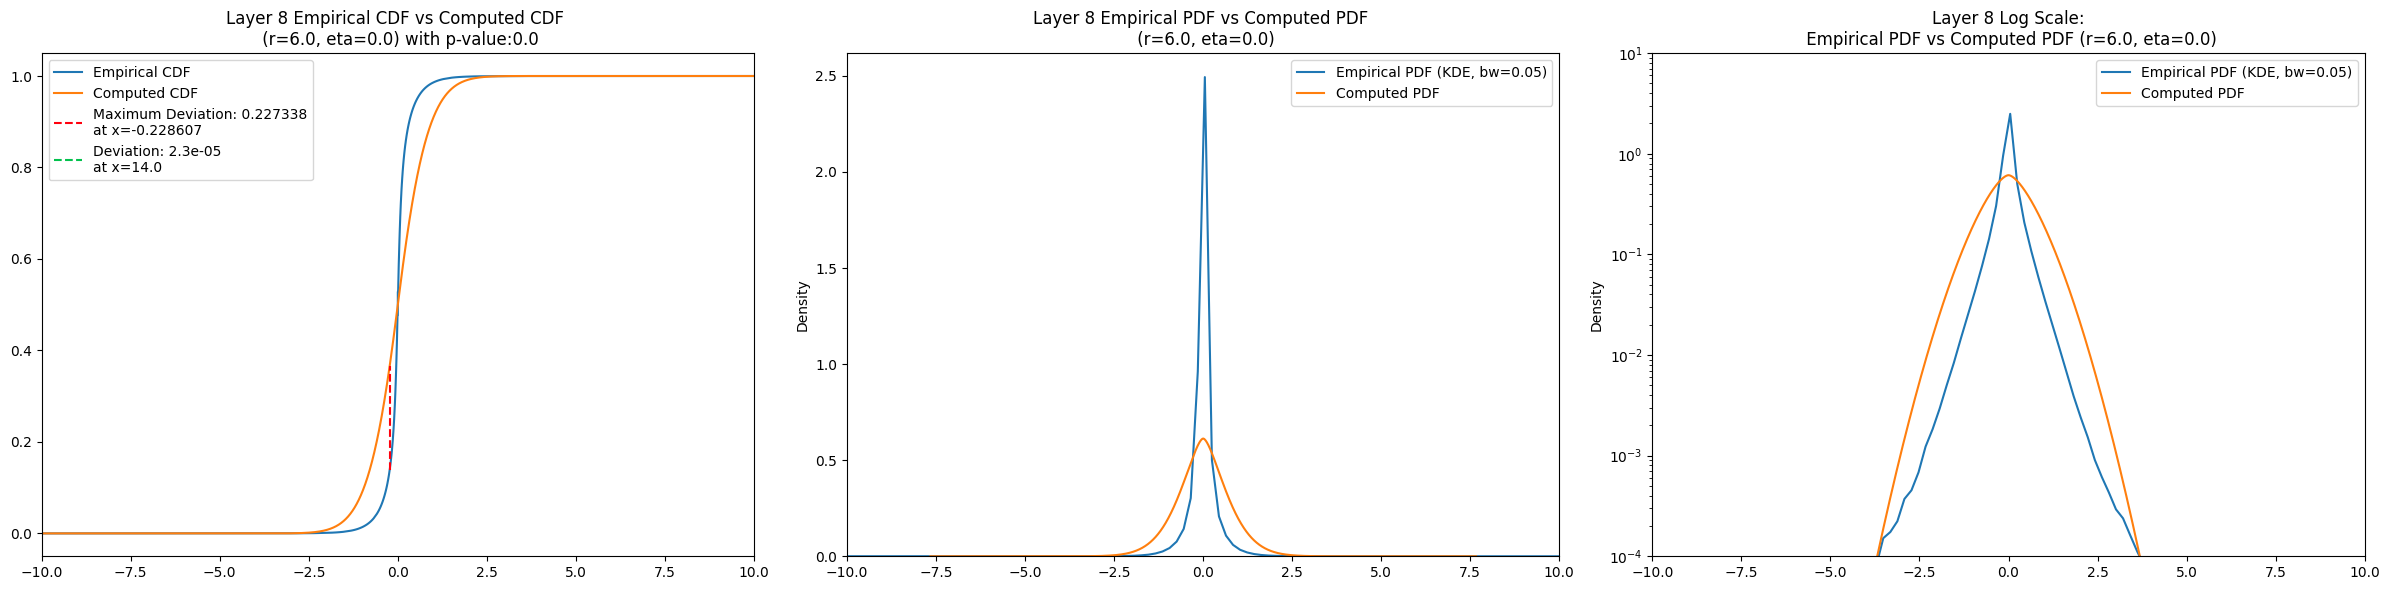

In [9]:
for group in np.arange(min_group, max_group+1):
    group_info = master_df.loc[group]
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (group_info[f'best_r_d{r_d}'], group_info[f'best_eta_d{eta_d}']), 
                    log_scale = True,
                    all_cdfs = combine_pickles(f'{GROUP}{group}_10000'),
                    group = group,
                    interval = (-(40 - group//3.1*15), (40 - group//3.1*15)),
                    provided_loc=(30 - group//3.1*8))
    fig.savefig(f'{DATA_NAME}/plots/compare_cdf_pdf_layer_{group}.png', bbox_inches = 'tight')

## Comparing with Gaussian and Laplace

In [10]:
SKIP_OPTIMIZE_STEP = True

def coord_descent_scipy(sample, initial_param):
    '''
    '''
    r_0, eta_0 = initial_param
    find_r_1 = scipy.optimize.minimize_scalar(generate_func(sample, 'gengamma_r', eta_0), method = 'bounded', bounds = (max(0.5, r_0-0.1), r_0+0.1))
    r_1 = find_r_1['x']
    find_eta_1 = scipy.optimize.minimize_scalar(generate_func(sample, 'gengamma_eta', r_1), method = 'bounded', bounds = (max(0, eta_0-0.1), eta_0+0.1))
    eta_1 = find_eta_1['x']
    find_r_2 = scipy.optimize.minimize_scalar(generate_func(sample, 'gengamma_r', eta_1), method = 'bounded', bounds = (max(0.5, r_1-0.1), r_1+0.1))

    r_2 = find_r_2['x']

    return r_2, eta_1, find_r_2['fun']

if SKIP_OPTIMIZE_STEP:
    master_df[f'best_r_scipy'], master_df[f'best_eta_scipy'], master_df[f'kstest_stat_cd_scipy'] =   master_df[f'best_r_d{r_d}'],  master_df[f'best_eta_d{eta_d}'], master_df['kstest_stat_initial']
else:
    for group in np.arange(min_group, max_group+1):
        master_df.loc[group, f'best_r_scipy'], master_df.loc[group, f'best_eta_scipy'], master_df.loc[group, f'kstest_stat_cd_scipy'] = coord_descent_scipy(group_data_map[group], master_df.loc[group, 'initial_param'])

master_df.to_csv(f'{DATA_NAME}/CSVs/master_df_post_cd_scipy.csv')
master_df = pd.read_csv(f'{DATA_NAME}/CSVs/master_df_post_cd_scipy.csv', index_col = 'layer')
master_df['initial_param'] = [tuple(float(i) for i in master_df.loc[layer]['initial_param'][1:-1].split(',')) for layer in master_df.index]
master_df


,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta0,kstest_stat_cutoff_0.05,kstest_stat_cd,best_r_d2,best_eta_d1,n_pval_0.05,best_r_scipy,best_eta_scipy,kstest_stat_cd_scipy
layer,,,,,,,,,,,,,
2,3180,"(0.39, 4.0)",0.021670,"(0.26, 0)",0.060374,0.024030,0.021670,0.39,4.0,4023,0.39,4.0,0.021670
3,12720,"(0.44, 3.7)",0.008143,"(0.29, 0)",0.037031,0.012029,0.008143,0.44,3.7,28620,0.44,3.7,0.008143
4,50880,"(0.44, 1.4)",0.006270,"(0.34, 0)",0.023245,0.006018,0.006270,0.44,1.4,48295,0.44,1.4,0.006270
5,203520,"(0.47, 0.2)",0.005235,"(0.44, 0)",0.005645,0.003010,0.005235,0.47,0.2,64395,0.47,0.2,0.005235
6,814080,"(0.74, 0.0)",0.020505,"(0.74, 0)",0.020505,0.001505,0.020505,0.74,0.0,4525,0.74,0.0,0.020505
7,3256320,"(6.1, 0.0)",0.082279,"(6.1, 0)",0.082279,0.000753,0.082279,6.10,0.0,279,6.10,0.0,0.082279
8,13025280,"(6.0, 0.0)",0.227356,"(6.0, 0)",0.227356,0.000376,0.227356,6.00,0.0,36,6.00,0.0,0.227356


In [11]:
for group in np.arange(min_group, max_group+1):
    norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, 50))
    laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, 50))
    t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, 50))
    
    master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
    master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'num_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

    master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
    master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'num_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

    master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
    master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'num_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

    master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
    master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'num_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

    master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'num_samples']).sf(min(master_df.loc[group, 'kstest_stat_cd'], master_df.loc[group, 'kstest_stat_cd_scipy'])), 6)

master_df.to_csv(f'{DATA_NAME}/CSVs/master_df_post_compare_priors.csv')
master_df = pd.read_csv(f'{DATA_NAME}/CSVs/master_df_post_compare_priors.csv', index_col = GROUP)
master_df['initial_param'] = [tuple(float(i) for i in master_df.loc[layer]['initial_param'][1:-1].split(',')) for layer in master_df.index]
master_df

,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta0,kstest_stat_cutoff_0.05,kstest_stat_cd,best_r_d2,best_eta_d1,n_pval_0.05,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,3180,"(0.39, 4.0)",0.021670,"(0.26, 0)",0.060374,0.024030,0.021670,0.39,4.0,4023,...,27.782300,0.019503,1.755550e-01,25.439100,0.036392,4.282210e-04,20.752800,0.036305,4.458110e-04,9.945980e-02
3,12720,"(0.44, 3.7)",0.008143,"(0.29, 0)",0.037031,0.012029,0.008143,0.44,3.7,28620,...,16.031400,0.010128,1.460870e-01,14.012900,0.022665,4.151010e-06,11.277100,0.026410,3.854630e-08,3.658630e-01
4,50880,"(0.44, 1.4)",0.006270,"(0.34, 0)",0.023245,0.006018,0.006270,0.44,1.4,48295,...,8.001070,0.020474,5.852830e-19,7.104980,0.014498,1.017140e-09,5.719650,0.018489,1.538450e-15,3.644850e-02
5,203520,"(0.47, 0.2)",0.005235,"(0.44, 0)",0.005645,0.003010,0.005235,0.47,0.2,64395,...,3.590120,0.030175,2.012920e-161,3.138820,0.002343,2.134870e-01,2.574020,0.010572,3.454100e-20,2.856240e-05
6,814080,"(0.74, 0.0)",0.020505,"(0.74, 0)",0.020505,0.001505,0.020505,0.74,0.0,4525,...,1.426170,0.042370,0.000000e+00,1.246790,0.014477,1.233750e-148,1.010520,0.017937,5.988230e-228,9.489030e-298
7,3256320,"(6.1, 0.0)",0.082279,"(6.1, 0)",0.082279,0.000753,0.082279,6.10,0.0,279,...,0.539642,0.052925,0.000000e+00,0.472750,0.025277,0.000000e+00,0.378316,0.026436,0.000000e+00,0.000000e+00
8,13025280,"(6.0, 0.0)",0.227356,"(6.0, 0)",0.227356,0.000376,0.227356,6.00,0.0,36,...,0.196018,0.056353,0.000000e+00,0.172564,0.029150,0.000000e+00,0.137348,0.028144,0.000000e+00,0.000000e+00


# Examining Tail Behavior

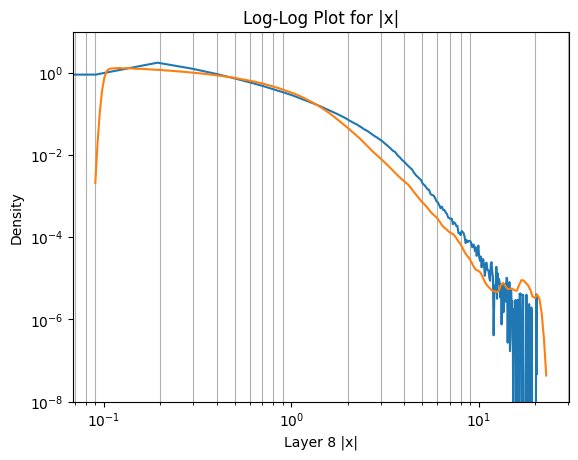

In [12]:
bw = 0.05
group = 7
x = np.abs(group_data_map[group])
fig = sns.kdeplot(x = x[x >= 0.1], bw_method = bw, label = f"Empirical PDF (KDE), bw={bw}")
fig.set_xscale('log')
fig.set_yscale('log')
fig.set_ylim(bottom = 10**-8, top=10)
plt.xlabel(f'Layer {group} |x|')
plt.title(f'Log-Log Plot for |x|')
plt.grid(True, 'minor')
plt.savefig(f'{DATA_NAME}/plots/log-log_plot_layer_7.png', bbox_inches = 'tight')

bw = 0.05
group = 8
x = np.abs(group_data_map[group])
fig = sns.kdeplot(x = x[x >= 0.1], bw_method = bw, label = f"Empirical PDF (KDE), bw={bw}")
fig.set_xscale('log')
fig.set_yscale('log')
fig.set_ylim(bottom = 10**-8, top=10)
plt.xlabel(f'Layer {group} |x|')
plt.title(f'Log-Log Plot for |x|')
plt.grid(True, 'minor')
plt.savefig(f'{DATA_NAME}/plots/log-log_plot_layer_8.png', bbox_inches = 'tight')


In [14]:
def add_metric_tail(metric_name = 'kstest_ratio',  distro = 'gengamma', tail_cutoffs = [0], layers = np.arange(2, 9)):
    if metric_name == 'kstest_ratio':
        metric = compute_ksratio
    elif metric_name == 'kstest_stat':
        metric = compute_ksstat_tail

    for tail_cutoff in tail_cutoffs:
        metrics = []
        for layer in layers:
            if distro == 'gengamma':
                cdf = all_cdfs[master_df.loc[layer, 'initial_param']]
            elif distro == 'gaussian':
                cdf = stats.norm(scale = master_df.loc[layer, 'param_gaussian']).cdf
            elif distro == 'laplace':
                cdf = stats.norm(scale = master_df.loc[layer, 'param_laplace']).cdf
            elif distro == 't':
                cdf = stats.t(df = 2, scale = master_df.loc[layer, 'param_t']).cdf
            metrics.append(metric(group_data_map[layer], cdf, tail_cutoff = tail_cutoff))
        master_df[metric_name + '_' + distro + '_' + f'tail{tail_cutoff}'] = metrics
        
for group in np.arange(min_group, max_group+1):
    add_metric_tail('kstest_ratio', distro = 'gengamma', tail_cutoffs= [0,10], layers = np.arange(2, 9))
    add_metric_tail('kstest_ratio', distro = 'gaussian', tail_cutoffs= [0,10], layers = np.arange(2, 9)) 
    add_metric_tail('kstest_ratio', distro = 'laplace', tail_cutoffs= [0,10], layers = np.arange(2, 9))
    add_metric_tail('kstest_ratio', distro = 't', tail_cutoffs= [0,10], layers = np.arange(2, 9))
    add_metric_tail('kstest_stat', distro = 'gengamma', tail_cutoffs= [2, 10], layers = np.arange(2, 9))

master_df.to_csv(f'{DATA_NAME}/CSVs/master_df.csv')

master_df = pd.read_csv(f'{DATA_NAME}/CSVs/master_df.csv', index_col = GROUP)
master_df['initial_param'] = [tuple(float(i) for i in master_df.loc[layer]['initial_param'][1:-1].split(',')) for layer in master_df.index]
master_df

,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta0,kstest_stat_cutoff_0.05,kstest_stat_cd,best_r_d2,best_eta_d1,n_pval_0.05,...,kstest_ratio_gengamma_tail0,kstest_ratio_gengamma_tail10,kstest_ratio_gaussian_tail0,kstest_ratio_gaussian_tail10,kstest_ratio_laplace_tail0,kstest_ratio_laplace_tail10,kstest_ratio_t_tail0,kstest_ratio_t_tail10,kstest_stat_gengamma_tail2,kstest_stat_gengamma_tail10
layer,,,,,,,,,,,,,,,,,,,,,
2,3180,"(0.39, 4.0)",0.021670,"(0.26, 0)",0.060374,0.024030,0.021670,0.39,4.0,4023,...,"(0.082446, 1.0161)","(0.082446, 1.0161)","(0.9368, 1.9545)","(0.9368, 1.9545)","(0.95089, 7.3557)","(0.95089, 7.3557)","(0.015521, 1.04)","(0.015521, 1.04)",0.021670,2.166960e-02
3,12720,"(0.44, 3.7)",0.008143,"(0.29, 0)",0.037031,0.012029,0.008143,0.44,3.7,28620,...,"(0.095485, 1.0197)","(0.095485, 1.0197)","(0.96671, 76.943)","(0.96671, 76.943)","(0.96151, 2839.9)","(0.96151, 2839.9)","(0.0074015, 1.1147)","(0.0074015, 1.1147)",0.008143,8.143188e-03
4,50880,"(0.44, 1.4)",0.006270,"(0.34, 0)",0.023245,0.006018,0.006270,0.44,1.4,48295,...,"(0.099159, 1.0029)","(0.099159, 1.0029)","(0.93633, 391120.0)","(0.97872, 391120.0)","(0.95756, 119260000.0)","(0.95756, 119260000.0)","(0.003275, 1.0744)","(0.003275, 1.0176)",0.005811,5.486526e-03
5,203520,"(0.47, 0.2)",0.005235,"(0.44, 0)",0.005645,0.003010,0.005235,0.47,0.2,64395,...,"(0.26455, 3376.1)","(0.26455, 3376.1)","(0.90723, 9.236e+34)","(0.98075, 9.236e+34)","(0.95007, 9.254e+46)","(0.97884, 9.254e+46)","(0.0034259, 1.0662)","(0.0034259, 1.0104)",0.003321,1.373036e-03
6,814080,"(0.74, 0.0)",0.020505,"(0.74, 0)",0.020505,0.001505,0.020505,0.74,0.0,4525,...,"(0.94647, 1556300.0)","(0.99916, 1556300.0)","(0.87957, 3.725e+56)","(0.99905, 3.725e+56)","(0.93638, 2.5142e+75)","(0.99905, 2.5142e+75)","(0.0013751, 1.2182)","(0.0013751, 1.0041)",0.019262,8.376645e-04
7,3256320,"(6.1, 0.0)",0.082279,"(6.1, 0)",0.082279,0.000753,0.082279,6.10,0.0,279,...,"(0.72838, 34048000000000.0)","(0.99998, 12787000000.0)","(0.85009, 2.0712000000000005e+268)","(0.99998, 2.0712000000000005e+268)","(0.90639, inf)","(0.99998, inf)","(0.0015714, 1.506)","(0.0015714, 1.0007)",0.016792,2.426051e-05
8,13025280,"(6.0, 0.0)",0.227356,"(6.0, 0)",0.227356,0.000376,0.227356,6.00,0.0,36,...,"(0.13028, 69281000000.0)","(1.0, 180970000.0)","(0.83652, inf)","(1.0, inf)","(0.89531, inf)","(1.0, inf)","(0.0028504, 1.7139)","(0.0028504, 1.0001)",0.006479,7.677378e-07


# Results

## KS-Test Statistics

In [ ]:
#master_df.filter(regex='num_samples|kstest_stat.*')
#master_df.filter(regex='num_samples|param.*')
# master_df.filter(regex='.*gaussian')
master_df.filter(regex='kstest_stat_.*[\_(tail\d)]')
#master_df.filter(regex='.*_tail\d\d?')
#master_df.filter(regex='.*_t_.*')


,kstest_stat_initial,kstest_stat_eta0,kstest_stat_cutoff_0.05,kstest_stat_cd_scipy,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t,kstest_stat_gengamma_tail2,kstest_stat_gengamma_tail10
layer,,,,,,,,,
2,0.021670,0.060374,0.024030,0.021670,0.019503,0.036392,0.036305,0.021670,2.166960e-02
3,0.008143,0.037031,0.012029,0.008143,0.010128,0.022665,0.026410,0.008143,8.143188e-03
4,0.006270,0.023245,0.006018,0.006270,0.020474,0.014498,0.018489,0.005811,5.486526e-03
5,0.005235,0.005645,0.003010,0.005235,0.030175,0.002343,0.010572,0.003321,1.373036e-03
6,0.020505,0.020505,0.001505,0.020505,0.042370,0.014477,0.017937,0.019262,8.376645e-04
7,0.082279,0.082279,0.000753,0.082279,0.052925,0.025277,0.026436,0.016792,2.426051e-05
8,0.227356,0.227356,0.000376,0.227356,0.056353,0.029150,0.028144,0.006479,7.677378e-07
